<a href="https://colab.research.google.com/github/kessingtonosazee/GCP_Project_1/blob/master/mlc_2324_w5_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Exercise: Cross Validation, Grid Search, Classification

* Machine Learning Concepts (MLC)
* Week 5, 2023/24
* Luciano Gerber

## Preamble: Importing and Configuring Essential Packages


In [30]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (6, 4) },
    style='ticks',
    color_codes=True,
    font_scale=0.8
)
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import sys
if 'google.colab' in sys.modules:
    !pip install -q dtreeviz
import dtreeviz

## Use Case: Titanic Dataset

In [31]:
# documentation can be found here: https://www.kaggle.com/competitions/titanic/data
titanic = pd.read_csv('https://raw.githubusercontent.com/gerberl/6G7V0015-2324/main/datasets/titanic.csv')

In [32]:
titanic.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [33]:
titanic['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

## Pre-Processing

In [34]:
# I'll make it possible for us to use `Sex` in our machine learning but
# mapping into a numeric feature using a simple strategy
tic = titanic.copy(deep=True)
tic['Sex'] = tic['Sex'].map({ 'male': 0, 'female': 1, np.NaN: 0} )
# Why not aggregate the number of people one travelled with?
tic['Companions'] = tic['SibSp'] + tic['Parch']
# remove categorical features (with string values) and other non-informative
# features
tic = tic[ ['Survived', 'Age', 'Sex', 'Pclass', 'Fare', 'Companions']]
# fill in missing values with the simplest strategy so as not to break the ML
tic = tic.fillna(tic.mean())

In [35]:
X, y = tic.drop(columns='Survived'), tic['Survived']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## A First Decision Tree for Illustration

0.7847891851011533 0.77068345323741


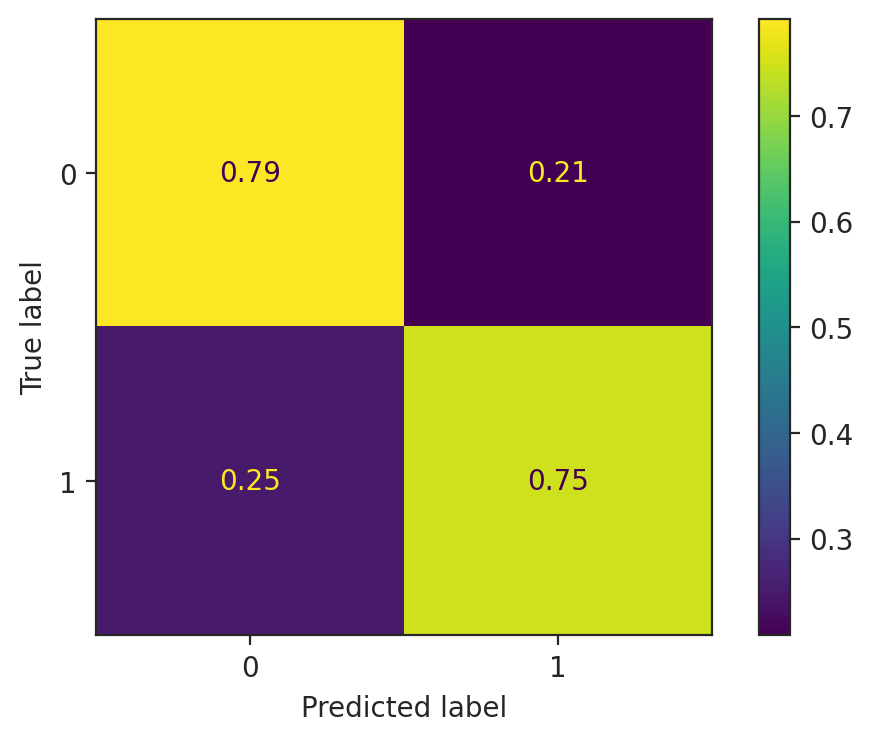

In [37]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)
print(
    balanced_accuracy_score(y_train, dt.predict(X_train)),
    balanced_accuracy_score(y_test, dt.predict(X_test))
)
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, dt.predict(X_test), normalize='true')
).plot();

|--- Sex <= 0.50
|   |--- Age <= 14.00
|   |   |--- class: 1
|   |--- Age >  14.00
|   |   |--- class: 0
|--- Sex >  0.50
|   |--- Pclass <= 2.50
|   |   |--- class: 1
|   |--- Pclass >  2.50
|   |   |--- class: 1



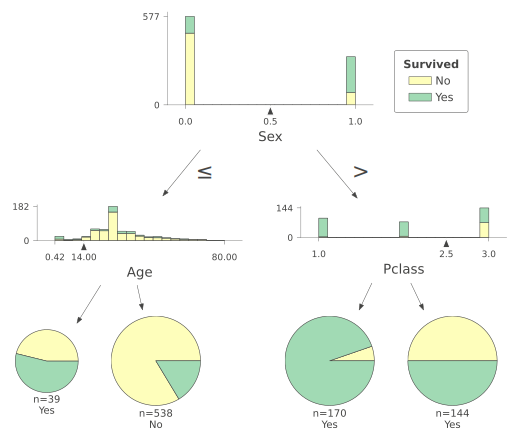

In [38]:
print(
    export_text(dt, feature_names=X.columns.to_list())
)
dtviz = dtreeviz.model(
    dt, X, y, target_name='Survived', feature_names=X.columns,
    class_names=["No", "Yes"]
)
dtviz.view(scale=1.5, fontname='sans-serif')

## Exercises - Your Turn

* Experiment with trees with different configurations, using hyper-parameters such as `max_depth`, `min_samples_split`, and `min_samples_leaf`. Make use of grid search for hyper-parameter search.

* For each, do a quick analysis of accuracy on train and test. If promising, you might want to go deeper and visualise the tree with `export_text` or `dtreeviz`, and use a confusion matrix for a better understanding of the model's performance.

* Make use of cross validation for the measurement of the accuracy of models on the training data.

* Use this week's lecture as inspiration for looking into the ranking of results and, together with the graphical representation of the tree, make a justified decision for one or more of the tree models built.

**Cross validation**

In [39]:
dtt = DecisionTreeClassifier(max_depth=3)
dtt.fit(X_train, y_train)
print(
    balanced_accuracy_score(y_train, dtt.predict(X_train)),
    balanced_accuracy_score(y_test, dtt.predict(X_test))
)

0.8160616373605596 0.8007022953066119


In [40]:
from sklearn.model_selection import cross_val_score

In [41]:
scores = cross_val_score(dtt, X, y, cv=5)
scores.mean(), scores.std()

(0.8114430983616849, 0.012674341383654898)

In [42]:
scores = cross_val_score(dtt, X, y, cv=10)
scores.mean(), scores.std()

(0.8137078651685392, 0.02970120104077843)

**Hyper-Parameter Search with Grid Search**

In [43]:
param_grid = {
    'max_depth': [ 1, 3, 4, 8 ],
    'min_samples_leaf': [ 10, 20, 30 ]
}

In [44]:
from sklearn.model_selection import ParameterGrid
# this is the Parameter Grid of the above: all possible combinations of the values
# of the two hyper-parameters (4 max_depth x 3 min_sample_leaf = 12 configuration)
list(ParameterGrid(param_grid))

[{'max_depth': 1, 'min_samples_leaf': 10},
 {'max_depth': 1, 'min_samples_leaf': 20},
 {'max_depth': 1, 'min_samples_leaf': 30},
 {'max_depth': 3, 'min_samples_leaf': 10},
 {'max_depth': 3, 'min_samples_leaf': 20},
 {'max_depth': 3, 'min_samples_leaf': 30},
 {'max_depth': 4, 'min_samples_leaf': 10},
 {'max_depth': 4, 'min_samples_leaf': 20},
 {'max_depth': 4, 'min_samples_leaf': 30},
 {'max_depth': 8, 'min_samples_leaf': 10},
 {'max_depth': 8, 'min_samples_leaf': 20},
 {'max_depth': 8, 'min_samples_leaf': 30}]

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
# Instantiate gridsearch
clf = GridSearchCV(dtt, param_grid, return_train_score=True)

In [47]:
# fit to data
gs_results = clf.fit(X_train, y_train)

In [48]:
# convert to dataframe
gs_df = pd.DataFrame(gs_results.cv_results_)

gs_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_leaf', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [49]:
gs_df.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.004033,0.001229,0.003777,0.001629,1,10,"{'max_depth': 1, 'min_samples_leaf': 10}",0.776119,0.798507,0.776119,...,0.788946,0.014158,8,0.792135,0.786517,0.792135,0.790654,0.783178,0.788924,0.003534


In [50]:
# sort performance metric

gs_df[ [
    'param_max_depth', 'param_min_samples_leaf',
    'mean_train_score', 'std_train_score',
    'mean_test_score', 'std_test_score', 'rank_test_score'
] ].sort_values('rank_test_score')

,param_max_depth,param_min_samples_leaf,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
3,3,10,0.829338,0.006388,0.811458,0.035447,1
5,3,30,0.809879,0.003318,0.797890,0.008491,2
8,4,30,0.809879,0.003318,0.797890,0.008491,2
11,8,30,0.809879,0.003318,0.797890,0.008491,2
6,4,10,0.835324,0.007227,0.794973,0.043143,5
4,3,20,0.818113,0.002267,0.793401,0.019919,6
9,8,10,0.849172,0.008491,0.792032,0.061849,7
0,1,10,0.788924,0.003534,0.788946,0.014158,8
1,1,20,0.788924,0.003534,0.788946,0.014158,8
2,1,30,0.788924,0.003534,0.788946,0.014158,8


In [51]:
# select best model
gs_results.best_params_

{'max_depth': 3, 'min_samples_leaf': 10}